# Notbook 2: Improvements on the Initial Fit #

### *Notebook summary...

In [1]:
# Common data science imports used in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic Python libraries used in this notebook
import time
import datetime
import os
import json

# A custom script I wrote to easily calculate and display classification metrics
import metrictools_snow as mts

# Tensorflow libraries for importing and preprocessing images
from tensorflow import io
from tensorflow import strings
from tensorflow import argmax
from tensorflow.data import AUTOTUNE
from tensorflow.data import Dataset
from tensorflow.image import resize_with_pad

# Building neural nets and loading saved models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.train import Checkpoint

The three cells below are copied exactly from the beginning of Notebook 1.  The image import process is the same as the process used there.

In [2]:
def get_image(file_path):
    
    # Given a Tensorflow filepath object, sets label to 0 if the second to last part of the path is 'clear' and 1 if it is 'snow'.
    parts = strings.split(file_path, os.path.sep)
    label = parts[-2] == ['clear', 'snow']
    
    # Reads in the image at the given filepath, which should be a jpeg.
    img = io.read_file(file_path)
    img = io.decode_jpeg(img)
    
    # Add buffer as necessary to resize image to 640x640 without changing aspect ratio.
    # 640 is the largest dimesion of any image in the dataset.
    img = resize_with_pad(img, 640, 640)
    
    # Normalize images so each pixel is in the range -1 to 1
    return (img - 127.5) / 127.5, argmax(label)

In [3]:
def get_data(img_folder_list, shuffle_seed, train_size=0.8):
    
    # Gets paths to all the files in the given folders holding the training data.  No shuffling is done yet.
    file_groups = [Dataset.list_files(folder+'*', shuffle=False) for folder in img_folder_list]
    
    # Will not run unless at least 2 data folders are passed, as folder names are used to determine image labels.
    if len(file_groups) > 1:
    
        # Join the filepaths from each folder into one variable.
        for i in range(1, len(file_groups)):
            image_paths = file_groups[0].concatenate(file_groups[i])

        # Filepaths are now shuffled.  This will be redone for each training epoch.
        # It's important to do the shuffling now, before images are read into memory.
        image_paths = image_paths.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True, seed=shuffle_seed)
    
        # Train/Test/Split based on train_size, which gives the proportion of images that should be used for training.
        train_paths = image_paths.take(int(len(image_paths)*train_size))
        val_paths = image_paths.skip(int(len(image_paths)*train_size))
    
        # Use the get_image function import the images, which are resized and normalized as they are imported.
        train_images = train_paths.map(get_image, num_parallel_calls=AUTOTUNE)
        val_images = val_paths.map(get_image, num_parallel_calls=AUTOTUNE)
        return train_images, val_images
    
    # If fewer than 2 folders were given, print the message below and return no data.
    else:
        print('Only one class found.  No data returned.')
        return None

In [4]:
# Execute the above functions to create Tensorflow Dataset objects for training.
folders = ['../data/train/clear/', '../data/train/snow/']
train_data, val_data = get_data(folders, shuffle_seed=632, train_size=0.8)

### Section VI: Importing and Preprocessing Images as Tensorflow Datasets ###

Although the neural net trained in Notebook 1 performed very well, I noticed while designing the streamlit app that it seemed to struggle to recognize more realistic pictures of falling snow, especially when the snow was wet or the flakes were small.  I'm training a new neural net with slightly smaller kernels and larger MaxPooling to try to highlight those smaller snowflakes.

A more proper gridsearch process would certainly be helpful, but would also be quite time-consuming, even with CUDA.  The original model already performed very well on the synthetic snow images in this dataset.  The problem of identifying wet or light snowfall may need to be addressed by training on a dataset containing more realistic snow pictures.  These considerations will be addressed as possibilities for future work in the Conclusions.

In [5]:
# Save an unbatched version of the data, which will make it easier to generate predictions and calculate metrics with them.
train_data_unbatched = train_data
val_data_unbatched = val_data

# Create batches for training and tell Tensorflow to fetch the next batch while each batch is being fit.
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [6]:
model = Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(4, 4),
                        strides=(2, 2),
                        activation='leaky_relu',
                        padding='same',
                        input_shape=[640, 640, 3]))

model.add(layers.MaxPooling2D(pool_size=(4, 4)))

model.add(layers.Conv2D(filters=8, kernel_size=(4, 4),
                       strides=(2, 2),
                       activation='leaky_relu',
                       padding='same'))

model.add(layers.MaxPooling2D(pool_size=(4, 4)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='leaky_relu'))

model.add(layers.Dense(8, activation='leaky_relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [8]:
history = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

Epoch 1/10
2500/2500 [==============================] - 282s 112ms/step - loss: 0.1462 - accuracy: 0.9402 - val_loss: 0.0660 - val_accuracy: 0.9780
Epoch 2/10
2500/2500 [==============================] - 295s 118ms/step - loss: 0.0693 - accuracy: 0.9751 - val_loss: 0.0865 - val_accuracy: 0.9672
Epoch 3/10
2500/2500 [==============================] - 294s 118ms/step - loss: 0.0533 - accuracy: 0.9813 - val_loss: 0.0492 - val_accuracy: 0.9830
Epoch 4/10
2500/2500 [==============================] - 294s 117ms/step - loss: 0.0460 - accuracy: 0.9842 - val_loss: 0.0395 - val_accuracy: 0.9856
Epoch 5/10
2500/2500 [==============================] - 293s 117ms/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.0382 - val_accuracy: 0.9857
Epoch 6/10
2500/2500 [==============================] - 292s 117ms/step - loss: 0.0355 - accuracy: 0.9872 - val_loss: 0.0256 - val_accuracy: 0.9904
Epoch 7/10
2500/2500 [==============================] - 292s 117ms/step - loss: 0.0331 - accuracy: 0.9880 - val_

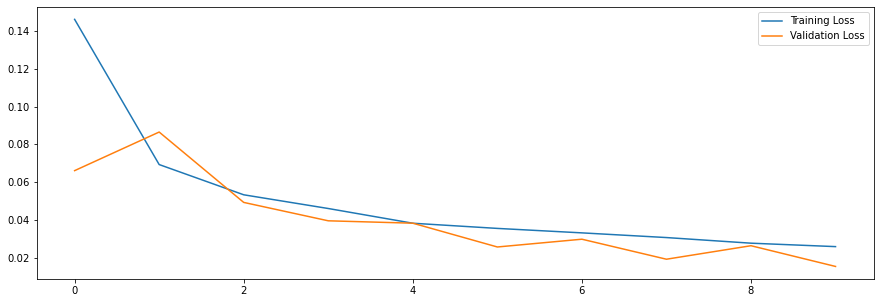

In [9]:
# Plot of the training and validation loss for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

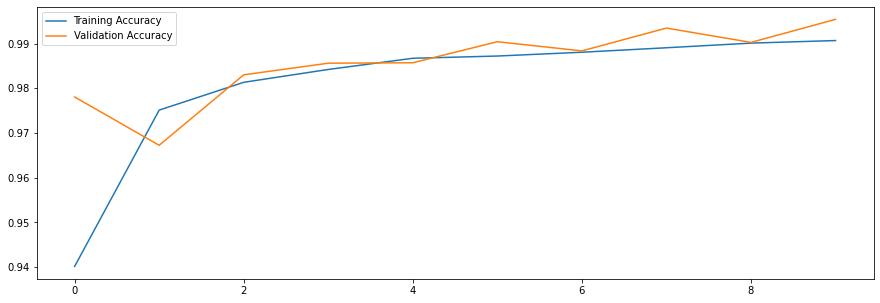

In [10]:
# Plot of the training and validation accuracy for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

In [11]:
model_name = 'model2'

In [12]:
model.save(f'../saved_models/{model_name}')

INFO:tensorflow:Assets written to: ../saved_models/model2\assets


In [13]:
history_dict = history.history
json.dump(history_dict, open(f'../saved_models/{model_name}_hist', 'w'))

The process of saving the model is identical to that used in Notebook 1, except that I now save the raw predictions to csv, rather than rounding and converting to int first.  This allows for later adjustment of the threshold for identifying an image as having snow.

I also improved get_preds to take the model as an argument, rather than hard-coding it into the function.

In [22]:
def get_preds(dataset, model, model_name, which_data):

    # Generating predictions on the data takes a while, so updates will be printed.
    # t_start saves the time that prediction generation began so the updates can include time elapsed.
    t_start = time.time()
    # Count and total are also used to inform the user of progress.
    count = 0
    total = len(dataset)
    
    preds = np.array([])
    true = np.array([])
    # Iterate through each image in the given dataset and corresponding label.
    for image, label in dataset:
        # Save the predicted and true label for each image in a numpy array.        
        preds = np.concatenate([preds, np.array([float(model.predict(image[np.newaxis, :]))])])
        true = np.concatenate([true, np.array([label.numpy()])])
        count += 1
        # Update the user after every 1000 predictions.
        if count % 1000 == 0:
            print(f'Calculated {count} of {total} predictions ({round(count * 100 / total, 2)}%) for {which_data} data. '
                  f'{datetime.timedelta(seconds=time.time()-t_start)} elapsed.')
    
    # Save the predictions and labels to a dataframe and then output them to a csv.
    df = pd.DataFrame(zip(true, preds), columns=['true', 'pred'])
    df.to_csv(f'../saved_models/{model_name}_{which_data}.csv', index=False)   
    
    # Return the predictions and labels in numpy arrays.
    return preds, true

In [23]:
# Obtain predictions and labels for validation data.
val_preds, val_true = get_preds(val_data_unbatched, model, model_name, 'val')

Calculated 1000 of 20000 predictions (5.0%) for val data. 0:00:50.717702 elapsed.
Calculated 2000 of 20000 predictions (10.0%) for val data. 0:01:38.899550 elapsed.
Calculated 3000 of 20000 predictions (15.0%) for val data. 0:02:28.999362 elapsed.
Calculated 4000 of 20000 predictions (20.0%) for val data. 0:03:18.693809 elapsed.
Calculated 5000 of 20000 predictions (25.0%) for val data. 0:04:08.705441 elapsed.
Calculated 6000 of 20000 predictions (30.0%) for val data. 0:04:58.377130 elapsed.
Calculated 7000 of 20000 predictions (35.0%) for val data. 0:05:48.112289 elapsed.
Calculated 8000 of 20000 predictions (40.0%) for val data. 0:06:37.923380 elapsed.
Calculated 9000 of 20000 predictions (45.0%) for val data. 0:07:27.755879 elapsed.
Calculated 10000 of 20000 predictions (50.0%) for val data. 0:08:17.473757 elapsed.
Calculated 11000 of 20000 predictions (55.0%) for val data. 0:09:07.171202 elapsed.
Calculated 12000 of 20000 predictions (60.0%) for val data. 0:09:56.959682 elapsed.
Ca

In [24]:
# Obtain predictions and labels for training data.
train_preds, train_true = get_preds(train_data_unbatched, model, model_name, 'train')

Calculated 1000 of 80000 predictions (1.25%) for train data. 0:00:48.823153 elapsed.
Calculated 2000 of 80000 predictions (2.5%) for train data. 0:01:35.115929 elapsed.
Calculated 3000 of 80000 predictions (3.75%) for train data. 0:02:24.142862 elapsed.
Calculated 4000 of 80000 predictions (5.0%) for train data. 0:03:13.997873 elapsed.
Calculated 5000 of 80000 predictions (6.25%) for train data. 0:04:03.819072 elapsed.
Calculated 6000 of 80000 predictions (7.5%) for train data. 0:04:54.049635 elapsed.
Calculated 7000 of 80000 predictions (8.75%) for train data. 0:05:44.120748 elapsed.
Calculated 8000 of 80000 predictions (10.0%) for train data. 0:06:34.047272 elapsed.
Calculated 9000 of 80000 predictions (11.25%) for train data. 0:07:24.241274 elapsed.
Calculated 10000 of 80000 predictions (12.5%) for train data. 0:08:14.286770 elapsed.
Calculated 11000 of 80000 predictions (13.75%) for train data. 0:09:04.366247 elapsed.
Calculated 12000 of 80000 predictions (15.0%) for train data. 0:

Here, I am recalculating the predictions from the model previously fit in Notebook 1.  This will allow me to adjust the snow threshold for that model as well and examine which model / threshold pairs give the most successful predictions.

In [25]:
load_model_name = 'test1'

In [26]:
loaded_model = load_model(f'../saved_models/{load_model_name}')

In [27]:
model_name = 'test1_float'

In [28]:
# Obtain predictions and labels for validation data.
val_preds, val_true = get_preds(val_data_unbatched, loaded_model, model_name, 'val')

Calculated 1000 of 20000 predictions (5.0%) for val data. 0:00:47.743125 elapsed.
Calculated 2000 of 20000 predictions (10.0%) for val data. 0:01:36.331267 elapsed.
Calculated 3000 of 20000 predictions (15.0%) for val data. 0:02:22.358140 elapsed.
Calculated 4000 of 20000 predictions (20.0%) for val data. 0:03:10.749100 elapsed.
Calculated 5000 of 20000 predictions (25.0%) for val data. 0:03:59.500582 elapsed.
Calculated 6000 of 20000 predictions (30.0%) for val data. 0:04:50.893102 elapsed.
Calculated 7000 of 20000 predictions (35.0%) for val data. 0:05:42.223875 elapsed.
Calculated 8000 of 20000 predictions (40.0%) for val data. 0:06:33.390822 elapsed.
Calculated 9000 of 20000 predictions (45.0%) for val data. 0:07:24.711838 elapsed.
Calculated 10000 of 20000 predictions (50.0%) for val data. 0:08:16.097984 elapsed.
Calculated 11000 of 20000 predictions (55.0%) for val data. 0:09:07.304653 elapsed.
Calculated 12000 of 20000 predictions (60.0%) for val data. 0:09:58.371003 elapsed.
Ca

In [30]:
# Obtain predictions and labels for training data.
train_preds, train_true = get_preds(train_data_unbatched, loaded_model, model_name, 'train')

Calculated 1000 of 80000 predictions (1.25%) for train data. 0:00:49.875344 elapsed.
Calculated 2000 of 80000 predictions (2.5%) for train data. 0:01:38.805669 elapsed.
Calculated 3000 of 80000 predictions (3.75%) for train data. 0:02:26.578628 elapsed.
Calculated 4000 of 80000 predictions (5.0%) for train data. 0:03:16.841484 elapsed.
Calculated 5000 of 80000 predictions (6.25%) for train data. 0:04:08.780794 elapsed.
Calculated 6000 of 80000 predictions (7.5%) for train data. 0:05:00.679279 elapsed.
Calculated 7000 of 80000 predictions (8.75%) for train data. 0:05:52.557606 elapsed.
Calculated 8000 of 80000 predictions (10.0%) for train data. 0:06:44.571676 elapsed.
Calculated 9000 of 80000 predictions (11.25%) for train data. 0:07:36.504208 elapsed.
Calculated 10000 of 80000 predictions (12.5%) for train data. 0:08:28.570555 elapsed.
Calculated 11000 of 80000 predictions (13.75%) for train data. 0:09:20.404369 elapsed.
Calculated 12000 of 80000 predictions (15.0%) for train data. 0: